# Scenario Extraction

In [1]:
%load_ext autoreload
%autoreload 2
import os
import csv
import json
import matplotlib.pyplot as plt
from traffic_object import TrafficObject
from tools import dump_json, maybe_makedirs
from objects import Scenario

#### HighD
In order to create a scenario ensemble we are going to search for a certain maneuver type in the HighD data set and extract a certain time range around it to generate a so called scenario.

The HighD data set consists of 60 recordings which were recorded at 6 different locations.
In the following we will only consider one recording but the context is not limited to include each of the recordings.

#### Set Constants
Next we have to define the root directory meaning the absolute folder in which the repositroy was cloned.

In [2]:
root_dir = '../' # This has to be the path to Problem folder (not the extraction folder)
recording_id = 18 # Shortest recording to limit computation

#### Load Data
Each recording from the HighD data set consists of 3 important files:
* a meta file of the recording itself (frame rate, location, time, etc..)
* a meta file for each object detected during the recording (type, direction, some pre-calculated risk measures, etc...)
* the recorded data listed for each frame (position, velocity, lane id, etc...)
    

In [3]:
# make a copy of the template dict and fill it for current recording
recording_dict = dict()
recording_dict['recording_meta_file'] = os.path.join(root_dir, 'highd', '{recording_id}_recordingMeta.csv').format(recording_id=str(recording_id).zfill(2))
recording_dict['tracks_meta_file'] = os.path.join(root_dir, 'highd', '{recording_id}_tracksMeta.csv').format(recording_id=str(recording_id).zfill(2))
recording_dict['tracks_file'] = os.path.join(root_dir, 'highd', '{recording_id}_tracks.csv').format(recording_id=str(recording_id).zfill(2))

# read the 3 required csv files for the current recording recording
recording_meta_reader = csv.DictReader(open(recording_dict['recording_meta_file']))
tracks_meta_reader = csv.DictReader(open(recording_dict['tracks_meta_file']))
tracks_reader = csv.DictReader(open(recording_dict['tracks_file']))
# read the only line from the meta file
recording_meta_row = list(recording_meta_reader)[0]

# create and init one traffic objects for each vehicle available in the recording
num_vehicles = int(recording_meta_row["numVehicles"])
to_dict = dict()
for vehicle_id in range(1, num_vehicles + 1):
    to = TrafficObject(vehicle_id, tracks_reader, tracks_meta_reader, recording_meta_row)
    # ignore traffic objects which have no appearance after ignoring the starting frames
    if len(to.time_stamps) == 0:  # this may happen because of config.extraction["discard_first_n_frames"]
        continue
    to_dict[vehicle_id] = to    

Each TrafficObject has access to all Traffic Objects within the same recording

In [4]:
# set the calculated traffic object dict for each traffic object
for vehicle_id in sorted(to_dict.keys()):
    to = to_dict[vehicle_id]
    to.set_others(to_dict)
len(list(to.to_dict.keys()))

607

### Filter out irrelevant traffic objects

Each of the following filter is run over each TrafficObject:

* The first filter we apply removes all Traffic Objects which do not drive in the same direction or do not share existence time. 

In [5]:
# determine the possible relevant other traffic objects for each traffic object (step 1)
for vehicle_id in sorted(to_dict.keys()):
    to = to_dict[vehicle_id]
    to.determine_possible_relevant_others()
to.possible_relevant_others

[594, 596, 598, 600, 602, 603, 604, 606]

* Second, we filter traffic objects which are to far away to make any impact.
* Optionally, we add a 8-car model as a filter. Thus a maximum of 8 vehicles around each Traffic Participant are extracted.

In [6]:
# determine the relevant other traffic objects for each traffic object (step 2 and 3)
for vehicle_id in sorted(to_dict.keys()):
    to = to_dict[vehicle_id]
    to.determine_relevant_others(include_8_car_filter=True)  # true = with 8 car filter, false = without 8 car filter
to.time_stamps[0].relevant_others

[606, 603]

### Extract Lane Change Maneuver
After having the filters applied we can extract the lane change maneuvers.
A maneuver is a schemantic description including the ID of the performing TrafficObject and the time frame as well as the type of the lane change.
During data loading it was already checked if a lane change occures by looking at the lane ID for each time step.

In [7]:
for vehicle_id in sorted(to_dict.keys()):
    to = to_dict[vehicle_id]
    to.extract_maneuvers()

### Extract Scenario for Maneuver
For each Maneuver we get all relevant Traffic Participants around the vehicle performing the lane change maneuver. Maneuver description + relevant Traffic Participants = Scenario

In [8]:
for vehicle_id in sorted(to_dict.keys()):
    to = to_dict[vehicle_id]
    to.extract_scenarios()

#### Save Scenarios and Visualization to File

In [9]:
maybe_makedirs(os.path.join(os.getcwd(), "data"))
maybe_makedirs(os.path.join(os.getcwd(), "figures"))
scenarios = list()
scenario_data = list()
counter = 1  # counter for marking the scenarios
for vehicle_id in sorted(to_dict.keys()):  # check every traffic object
    to = to_dict[vehicle_id]
    for s in to.scenario_list:  # check every lane change maneuver for this traffic object
        if len(s.traffic_objects_id) > 0:  # include scenario only if other traffic objects are involved

            # set the unique scenario number
            s.scenario_number = counter

            # appedn the scenario to the list for later meta data extraction 
            scenarios.append(s)

            # create file name
            file_name_data = os.path.join(os.getcwd(), "data", "scenario_" + str(s.scenario_number).zfill(3) + ".json")
            file_name_pic = os.path.join(os.getcwd(), "figures", "scenario_" + str(s.scenario_number).zfill(3) + ".png")

            # dump to json
            df = s.evaluate(to_dict)
            df = df.reset_index()
            scenario_data.append(df)
            dump_json(file_name_data, json.loads(df.to_json(orient='records')))

            # create picture
            s.plot_scenario(df, file_name=file_name_pic, m_type=s.maneuver.maneuver_type)
            plt.close()

            # update counter
            counter += 1


Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/data/scenario_001.json
Writing picture: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/figures/scenario_001.png
Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/data/scenario_002.json
Writing picture: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/figures/scenario_002.png
Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/data/scenario_003.json
Writing picture: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/figures/scenario_003.png
Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/data/scenario_004.json
Writing picture: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/figures/scenario_004.png
Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/data/scenario_005.json
Writing picture: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/figures/scenario_005.png
Writing dump: /

You can also use the plot function to show a certain scenario here in the notebook.

/Users/kitty/anaconda3/envs/tools_network/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


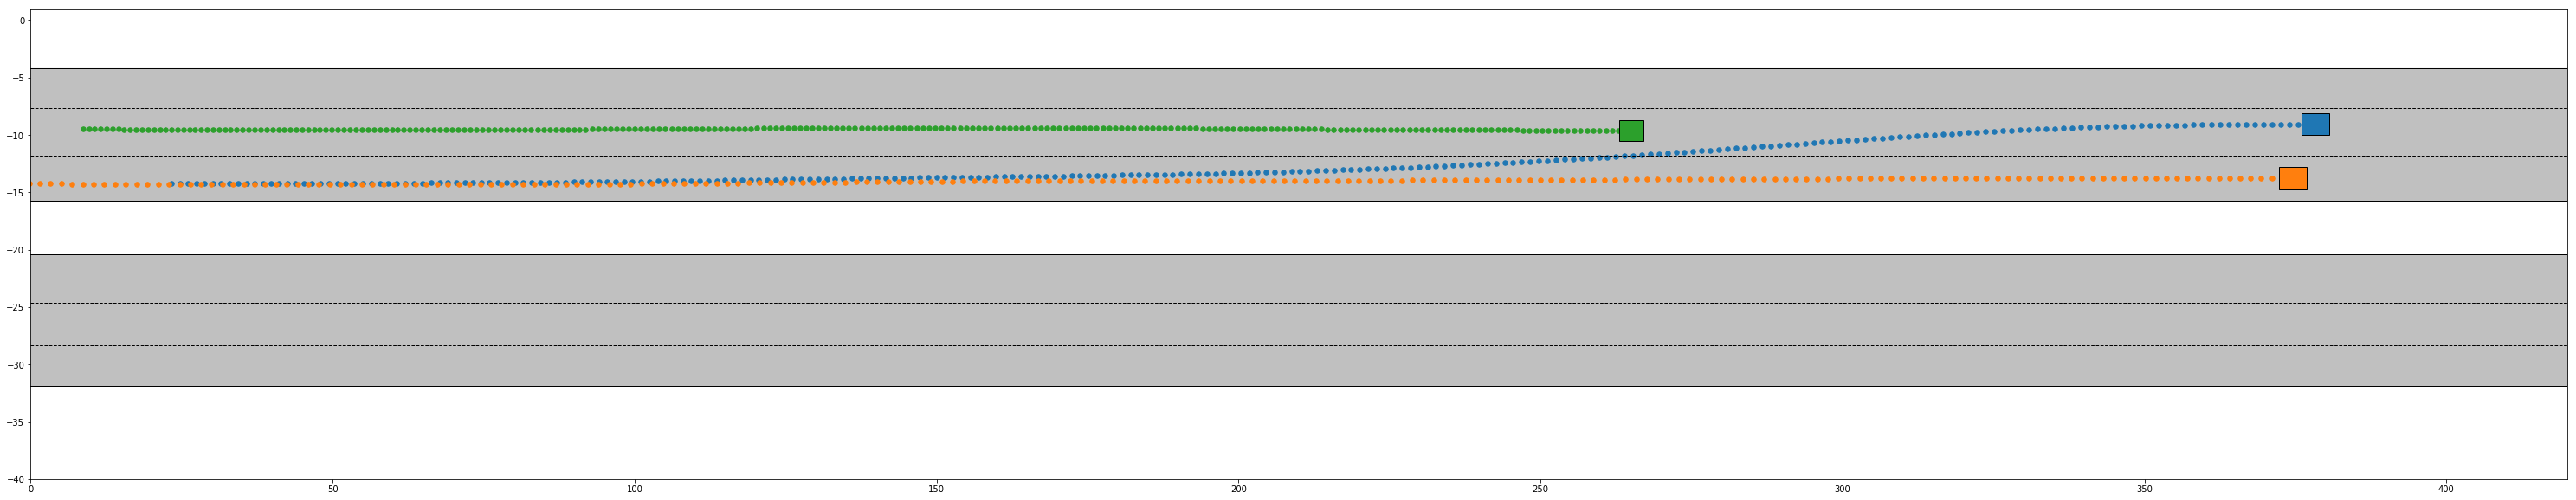

In [10]:
fig = Scenario.plot_scenario(scenario_data[5], save_fig=False)
fig.show()

Lastly, extract the type of the lane changes in the meta folder.

In [11]:
maybe_makedirs(os.path.join(os.getcwd(), "meta"))
file_name_meta = os.path.join(os.getcwd(), "meta", "maneuver_meta.json") 
Scenario.save_meta(file_name_meta, scenarios)

Writing dump: /Users/kitty/GitRepos/RandomRepos/stanford-2019/extraction/meta/maneuver_meta.json
